<a href="https://colab.research.google.com/github/yuntai/yuntai/blob/master/NIPA2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is prepaed for "2020 인공지능 문제해결 경진대회 (예선)". Most parts is adopted from https://github.com/alipay/cvpr2020-plant-pathology

In [1]:
# TPU setup per https://pytorch-lightning.readthedocs.io/en/latest/tpu.html
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [1]:
!pip install pytorch_lightning sklearn pretrainedmodels
!pip install -U albumentations 

     |████████████████████████████████| 542kB 9.2MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 276kB 31.9MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 829kB 44.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=b0a9c2c224d81c7a879556e7838b71511090d594448069f96d016c9b4d4eada2
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=e5edde67fa8b247b641f7f63ae6501a44d5fb4d58a709905b2e0951d63c704bb
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=1dd937cd30451ceb11e7261455cd1692994b69f7f8ff487c635e8991c38602a6
  Stored in directory: /r

In [2]:
import sys
from google.colab import drive
from pathlib import Path
running_in_colab = 'google.colab' in sys.modules
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cp "/content/drive/My Drive/NIPA_하반기 경진대회_사전검증.tar" .

In [5]:
!tar -xf "NIPA_하반기 경진대회_사전검증.tar"

In [4]:
import pandas as pd
import pretrainedmodels
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, f1_score
import os

from albumentations import (
  Compose,                
  GaussianBlur,           
  HorizontalFlip,         
  MedianBlur,             
  MotionBlur,             
  Normalize,              
  OneOf,                  
  RandomBrightness,       
  RandomContrast,         
  Resize,                 
  ShiftScaleRotate,       
  VerticalFlip,           
)                           

In [23]:
train_df.columns

Index(['fn', 'l0', 'l1', 'label'], dtype='object')

In [98]:
test_df = pd.read_csv('test/test.tsv', header=None)
test_df.columns = ['fn']
test_df['label'] = -1
test_df

,fn,label
0,0.jpg,-1
1,1.jpg,-1
2,2.jpg,-1
3,3.jpg,-1
4,4.jpg,-1
...,...,...
3992,3992.jpg,-1
3993,3993.jpg,-1
3994,3994.jpg,-1
3995,3995.jpg,-1


In [141]:
train_df = pd.read_csv('train/train.tsv', sep='\t', header=None)
train_df.columns = ['fn', 'l0', 'l1']
train_df['label'] = train_df.groupby(['l0','l1']).ngroup()
num_classes = train_df.label.max() + 1

In [91]:
label_map = train_df.groupby('label')[['l0','l1']].first().reset_index(drop=False)

Index(['label', 'l0', 'l1'], dtype='object')

In [11]:
fn = !ls train/*.jpg|head -1

CPU times: user 19.4 ms, sys: 467 µs, total: 19.9 ms
Wall time: 22.9 ms


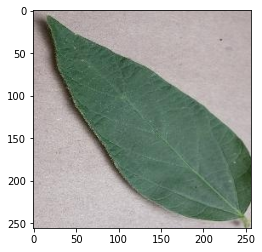

In [12]:
%%time 
img = cv2.cvtColor(cv2.imread(fn[0]), cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [8]:
backbone = pretrainedmodels.__dict__["se_resnext50_32x4d"]()
backbone.input_size

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


[3, 224, 224]

In [12]:
backbone

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (se_module): SEModule(
     

In [15]:
nets = list(backbone.children())[:-2]
# output of stem
print(nn.Sequential(*nets)(torch.FloatTensor(img.transpose(2,0,1))[None]).shape)
# with classification head
nets += [nn.AvgPool2d(kernel_size=8, stride=1, padding=0), nn.Flatten()]
print(nn.Sequential(*nets)(torch.FloatTensor(img.transpose(2,0,1))[None]).shape)

torch.Size([1, 2048, 8, 8])
torch.Size([1, 2048])


In [61]:
def generate_transforms(image_size):                                                                       
  train_transform = Compose([                                                                                                  
    #Resize(height=image_size[0], width=image_size[1]),                                             
    OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),                     
    OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
    VerticalFlip(p=0.5),                                                                           
    HorizontalFlip(p=0.5),                                                                         
    ShiftScaleRotate(                                                                              
        shift_limit=0.2,                                                                           
        scale_limit=0.2,                                                                           
        rotate_limit=20,                                                                           
        interpolation=cv2.INTER_LINEAR,                                                            
        border_mode=cv2.BORDER_REFLECT_101,                                                        
        p=1,                                                                                       
    ), 
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0)                                                                                            
  ])                                                                                                      
                                                                                                          
  val_transform = Compose([                                                                                                  
    #Resize(height=image_size[0], width=image_size[1]),                                             
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0)                                                                                            
  ])                                                                                                      
                                                                                                          
  return {"train": train_transform, "val": val_transform}                          
  
transforms = generate_transforms((256, 256))

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2588: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [56]:
class PlantDataset(Dataset):                                                                             
  def __init__(self, df, transforms, imgroot):
    self.df = df
    self.transforms = transforms
    self.imgroot = imgroot
                                                                                                         
  def __getitem__(self, ind):                                                                        
    fn = os.path.join(self.imgroot, self.df.iloc[ind, 0])
    img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)                                                                                               
    img = self.transforms(image=img)["image"].transpose(2, 0, 1)                             
    label = torch.tensor(self.df.iloc[ind, -1])
    return img, label
                                                                                                         
  def __len__(self):
    return len(self.df)

In [50]:
class LitClassifier(pl.LightningModule):
    def __init__(self):                                                                                     
        super().__init__()                                                                                           
        backbone = pretrainedmodels.__dict__["se_resnext50_32x4d"]()
        nets = list(backbone.children())[:-2] + [nn.AvgPool2d(kernel_size=8, stride=1, padding=0), nn.Flatten(), nn.Linear(in_features=2048, out_features=num_classes, bias=True)]
        self.model = nn.Sequential(*nets)
        self.criterion = nn.CrossEntropyLoss()
                                                                                                                     
    def forward(self, x):                                                                                            
        return self.model(x)                                                                                         
                                                                                                                     
    def configure_optimizers(self):                                                                                  
        return torch.optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
                                                                                                                     
    def training_step(self, batch, batch_idx):                                                                       
        imgs, y = batch                                                                                            
        y_hat = self.model(imgs)                                                                                   
        loss = self.criterion(y_hat, y)                                                                              
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)                      
        return loss                                                                                                  

    def validation_step(self, batch, batch_idx):                                                                     
        imgs, y = batch

        y_hat = self.model(imgs)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'preds': y_hat, 'labels': y}
                                                                                                                     
    def validation_epoch_end(self, outputs):                                                                         
        preds = torch.cat([o['preds'] for o in outputs], dim=0)                                                      
        labels = torch.cat([o['labels'] for o in outputs], dim=0)                                                    
        f1 = f1_score(labels.cpu().numpy(), preds.argmax(dim=-1).cpu().numpy(), average='macro')                                               
        self.log('val_f1', f1, prog_bar=True, logger=True)                                                          


In [139]:
RUN_TRAINING = True

In [ ]:
ckptdir = "drive/My Drive/ckpts"
if RUN_TRAINING:
    labels = train_df.label.values
    skf = StratifiedKFold()
    for fold_i, (train_ind, val_ind) in enumerate(skf.split(np.zeros_like(labels), labels)):
        if fold_i < 4: continue
        checkpoint_callback = ModelCheckpoint(                                                                   
            monitor="val_loss",                                                                               
            save_top_k=6,                                                                                        
            mode="min",                                                                                          
            filepath=os.path.join(ckptdir, f"fold={fold_i}"+"-{epoch}-{val_loss:.4f}-{val_f1:.4f}"),
            verbose=True,                                                                                        
        )                                                                                                        
        early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, mode="min", verbose=True)        

        tr_df = train_df.iloc[train_ind].reset_index(drop=True)
        va_df = train_df.iloc[val_ind].reset_index(drop=True)
    
        train_dataset = PlantDataset(tr_df, transforms['train'], 'train')
        val_dataset = PlantDataset(va_df, transforms['val'], 'train')
        train_dataloader = DataLoader(          
            train_dataset,                      
            batch_size=16,
            shuffle=True,                       
            num_workers=8,
            pin_memory=True,                    
            drop_last=True,                     
        )                                       
        val_dataloader = DataLoader(            
            val_dataset,                        
            batch_size=16,
            shuffle=False,                      
            num_workers=8,
            pin_memory=True,                    
            drop_last=False,                    
        )                                        
        model = LitClassifier()
        trainer = pl.Trainer(                               
            min_epochs=10,                                  
            max_epochs=30,
            callbacks=[early_stop_callback],                
            checkpoint_callback=checkpoint_callback,        
            #progress_bar_refresh_rate=0,                   
            #tpu_cores=8, 
            gpus=-1,
            precision=16,
            num_sanity_val_steps=0,
            profiler=False,
            weights_summary=None,
            gradient_clip_val=1,
            distributed_backend='ddp',
            fast_dev_run=False,                             
        )                                                   
        trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Missing logger folder: /content/lightning_logs
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1


Epoch 0: val_loss reached 0.26817 (best 0.26817), saving model to /content/drive/My Drive/ckpts/fold=4-epoch=0-val_loss=0.2682-val_f1=0.9143.ckpt as top 6


Epoch 1: val_loss reached 0.20780 (best 0.20780), saving model to /content/drive/My Drive/ckpts/fold=4-epoch=1-val_loss=0.2078-val_f1=0.9414.ckpt as top 6


Epoch 2: val_loss reached 0.11466 (best 0.11466), saving model to /content/drive/My Drive/ckpts/fold=4-epoch=2-val_loss=0.1147-val_f1=0.9640.ckpt as top 6


Epoch 3: val_loss reached 0.07656 (best 0.07656), saving model to /content/drive/My Drive/ckpts/fold=4-epoch=3-val_loss=0.0766-val_f1=0.9758.ckpt as top 6


In [48]:
def pick_best_ckpt(ckptdir):
    n_splits = 5
    ens_ckpts = []
    for fold_i in range(n_splits):
        ckpts = list(Path(ckptdir).glob(f"fold={fold_i}*"))
        __extract_loss = lambda x: float(x.stem.split('-')[2].split('=')[-1])
        __extract_f1 = lambda x: float(x.stem.split('-')[3].split('=')[-1])
        ckpts = [c for c in ckpts if __extract_f1(c) > 0.9]
        ens_ckpts.append(min(ckpts, key=lambda c: __extract_loss(c)))
    return ens_ckpts        

ckpts = pick_best_ckpt(ckptdir)
for c in ckpts:
    print(str(c))

[PosixPath('drive/My Drive/ckpts/fold=0-epoch=12-val_loss=0.0242-val_f1=0.9922.ckpt'), PosixPath('drive/My Drive/ckpts/fold=1-epoch=21-val_loss=0.0182-val_f1=0.9934.ckpt'), PosixPath('drive/My Drive/ckpts/fold=2-epoch=12-val_loss=0.0593-val_f1=0.9894.ckpt'), PosixPath('drive/My Drive/ckpts/fold=3-epoch=23-val_loss=0.0147-val_f1=0.9956.ckpt'), PosixPath('drive/My Drive/ckpts/fold=4-epoch=6-val_loss=0.0651-val_f1=0.9812.ckpt')]


In [69]:
model = LitClassifier()

tta_ensemble_cnt = 8
test_dataset = PlantDataset(test_df, transforms['train'], 'test')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)                                                                                                                 
submission = []

for ckpt in ckpts:
    print(f"`running {ckpt}`")
    model.load_state_dict(torch.load(ckpt)["state_dict"])
    model.cuda()
    model.eval()                                         

    for _ in range(tta_ensemble_cnt):
        preds = []                                      
        with torch.no_grad():                                
            for image, _ in test_dataloader:
                preds.append(model(image.cuda()).cpu())
            submission.append(torch.cat(preds))

running drive/My Drive/ckpts/fold=0-epoch=12-val_loss=0.0242-val_f1=0.9922.ckpt
running drive/My Drive/ckpts/fold=1-epoch=21-val_loss=0.0182-val_f1=0.9934.ckpt
running drive/My Drive/ckpts/fold=2-epoch=12-val_loss=0.0593-val_f1=0.9894.ckpt
running drive/My Drive/ckpts/fold=3-epoch=23-val_loss=0.0147-val_f1=0.9956.ckpt
running drive/My Drive/ckpts/fold=4-epoch=6-val_loss=0.0651-val_f1=0.9812.ckpt


In [78]:
import torch.nn.functional as F
submission_ensembled = 0                                          
for sub in submission:                                            
    submission_ensembled += F.softmax(sub, dim=-1) / len(submission)

test_df.label = submission_ensembled.argmax(dim=-1)
sub_df = test_df.reset_index(drop=False).merge(label_map, on=['label'], how='inner', sort=False).sort_values('index').drop(['index','label'], axis=1).reset_index(drop=True)
sub_df

In [134]:
subfn = 'submission.csv'
sub_df.to_csv(subfn, sep='\t', header=None, index=None)
!head {subfn}

In [138]:
from google.colab import files
files.download(subfn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>